In [1]:
%load_ext autoreload
%autoreload 2
from labeling import *
from scipy.ndimage import gaussian_filter1d, gaussian_filter
from scipy.interpolate import RegularGridInterpolator
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.colors as plc
import matplotlib.cm as cm

## Data and model information

In [2]:
fn = '../define_path.txt'     #add your path
with open(fn) as f:
    lines = f.readlines()
for idx, line in enumerate(lines):
    if idx == 1:
        dir_co2 = line.split('=')[1][:-1]
    if idx == 3:
        dir_grid = line.split('=')[1][:-1]

In [3]:
# loading data class for reference grid information
fn = f'{dir_co2}/10p10/data/10p10nea.sgy'    #add your path
d = dataload(fn=fn)

Total trace number: 150909
Sample number along each trace: 1001
Sampling interval along each trace: 0.002 s
data arrangement: 269 (number of ensembles) x 561 (trace number per ensemble) x 1001 (sample number per trace)


In [4]:
# get the entire dataset
di,xd,yd,td = d.getdata()
nt = len(td) # number of samples per trace

In [5]:
# depth surface and interval velocity class
S = surfaces(dir_grid=dir_grid)

In [6]:
# get the depth surfaces and corresponding corrdinates
D,xs,ys = S.get_data(S.path_ds,S.fnd,flip=True)
nfd = D.shape[0]

In [7]:
# expand depth surfaces according to xd,yd
eds = expand_xy(xs,ys,xd,yd)
De = eds.expand_m(D)

In [8]:
xyd = np.stack((xd.flatten(),yd.flatten()),axis=1)
# interpolate depth srufaces from De to Di in the expanded coordinates
Di = np.zeros((nfd,d.nx,d.ny),dtype=np.float32)
for i in range(nfd):
    funDi = RegularGridInterpolator((eds.xv,eds.yv), De[i])
    Di[i] = np.reshape(funDi(xyd),(d.nx,d.ny))
    #RectBivariateSpline(eds.xv,eds.yv,De[i])
    #Di[i] = funDi.ev(xd,yd)

In [9]:
# get the interval velocity and corresponding corrdinates
V,xv,yv = S.get_data(S.path_vs,S.fnv,flip=True)
nfv = V.shape[0]
sidx = [1,2,-1] 

In [10]:
# expand depth surfaces according to xd,yd
edv = expand_xy(xv,yv,xd,yd)
Ve = edv.expand_m(V)

In [11]:
# interpolate depth srufaces from De to Di in the expanded coordinates
Vi = np.zeros((nfv,d.nx,d.ny),dtype=np.float32)
for i in range(nfv):
    funVi = RegularGridInterpolator((edv.xv,edv.yv),Ve[i])
    Vi[i] = np.reshape(funVi(xyd),(d.nx,d.ny))

In [12]:
# CO2 plume boundaries
cpb = CO2_pb(dir_grid=dir_grid)

## Attempt to invert for CO2 layer thickness

### Some information for inverting CO2 layer thickness

(1800.0, 2200.0)

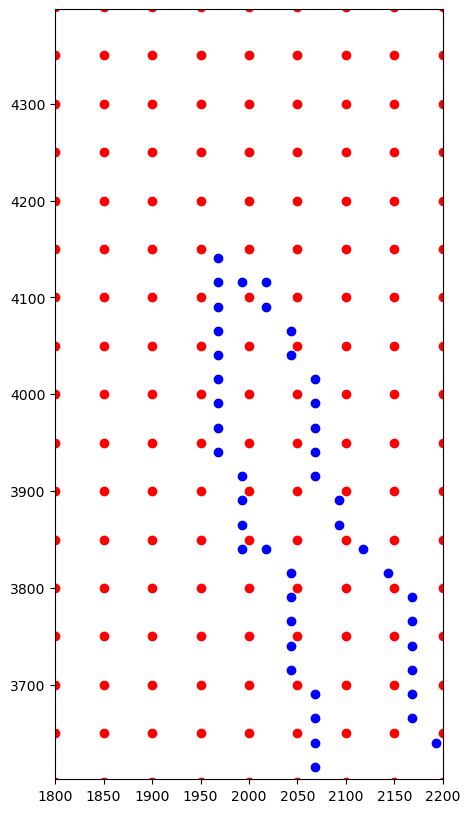

In [13]:
xm = np.amin(xs)
ym = np.amin(ys)
fig,ax = plt.subplots(1,1,figsize=(5,10))
ax.scatter(xs-xm,ys-ym,c='r')
ax.scatter(cpb.xb[1]-xm,cpb.yb[1]-ym,c='b')
ax.axis('equal')
ax.set_ylim(3800,4200)
ax.set_xlim(1800,2200)

In [14]:
# interpolate depth srufaces from De to Di in the expanded coordinates
Dpbt = []
Dpbb = []
tk = []
for i in range(cpb.nf):
    funDi = RegularGridInterpolator((eds.xv,eds.yv),De[nfd-(i+1)*2])
    Dpbt.append(funDi(np.stack((cpb.xb[i],cpb.yb[i]),axis=1)))
    funDi = RegularGridInterpolator((eds.xv,eds.yv),De[nfd-(i+1)*2+1])
    Dpbb.append(funDi(np.stack((cpb.xb[i],cpb.yb[i]),axis=1)))
for i in range(cpb.nf):    
    tk.append(Dpbb[i]-Dpbt[i])

In [15]:
# add the thickness of co2 layer on the boundary
Dpb0 = []
for i in range(cpb.nf):
    Dpb0.append(Dpbt[i]+cpb.ab[i]*20)

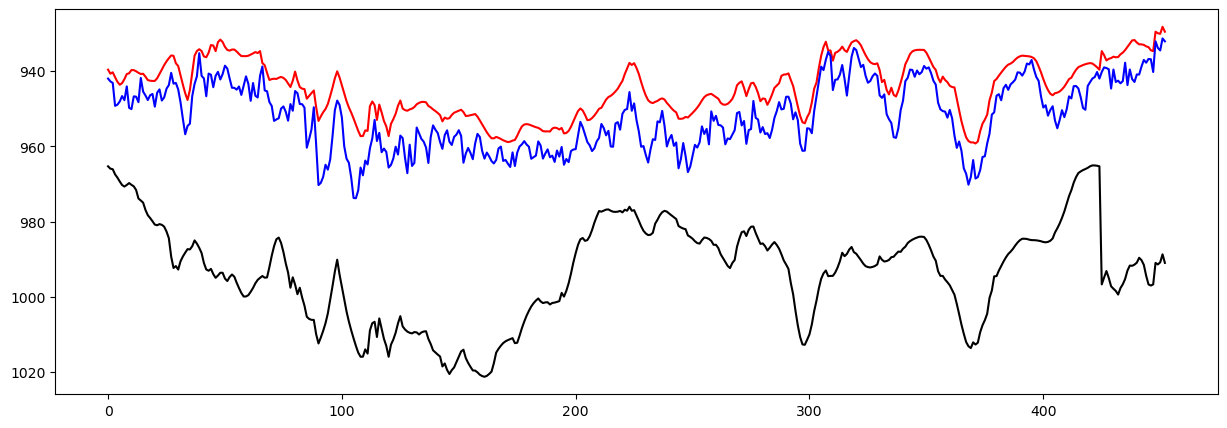

In [16]:
fig,ax = plt.subplots(1,1,figsize=(15,5))
ax.plot(Dpbt[-8],'r')
ax.plot(Dpbb[-8],'k')
ax.plot(Dpb0[-8],'b')
ax.invert_yaxis()

### Equation for co2 thickness inversion
$$ J = \lVert \nabla^2d(x,y)\rVert_2^2 $$
s.t.,
$$ d(x_b,y_b) = d_0 $$
$$ d_{st}\le d(x,y)\le d_{sb}$$

## Display the deepest Depth surface with CO2 plume boundary

ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

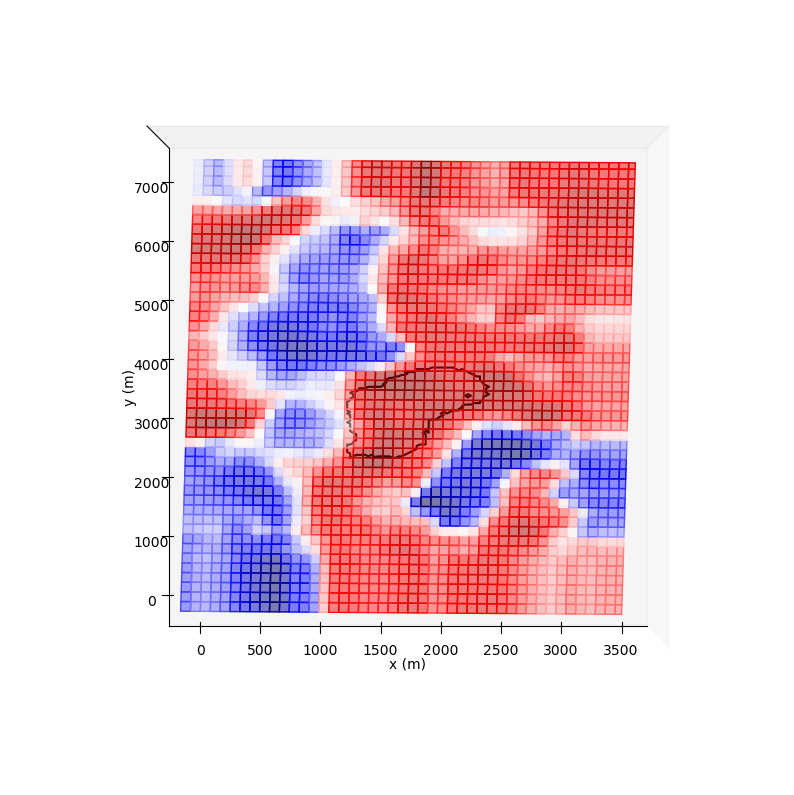

In [17]:
i = -1
LNo = 0
PlgNo = [0,1]
xb_layer,yb_layer,pn_layer = cpb.xb[LNo],cpb.yb[LNo],cpb.pn[LNo]
# plot the plume boundary
fig = plt.figure(figsize=(10,17))
ax = fig.add_subplot(111, projection='3d')
cN = plc.Normalize(vmin=np.amin(De[i]), vmax=np.amax(De[i]))
colors2 = plt.cm.seismic(cN(Di[i]))
ax.plot_surface(xd-np.amin(xd),yd-np.amin(yd),np.zeros_like(yd),
                facecolors=colors2,alpha=0.5,shade=False)
for i in PlgNo:
    mask = (pn_layer==i)
    xbi = xb_layer[mask]
    ybi = yb_layer[mask]
    xbi = np.append(xbi,xbi[0])
    ybi = np.append(ybi,ybi[0])
    ax.plot(xbi-np.amin(xd),ybi-np.amin(yd),zs=np.zeros(len(xbi))-0.01,color='k')

ax.view_init(elev=90,azim=-90)
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
#ax.invert_xaxis()
ax.grid(False)
_ = ax.set_zticks([])
cb = fig.colorbar(cm.ScalarMappable(norm=cN, cmap='seismic'))
cb.ax.tick_params(labelsize=25)

## Display the middle interval velocity with CO2 plume boundary

ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

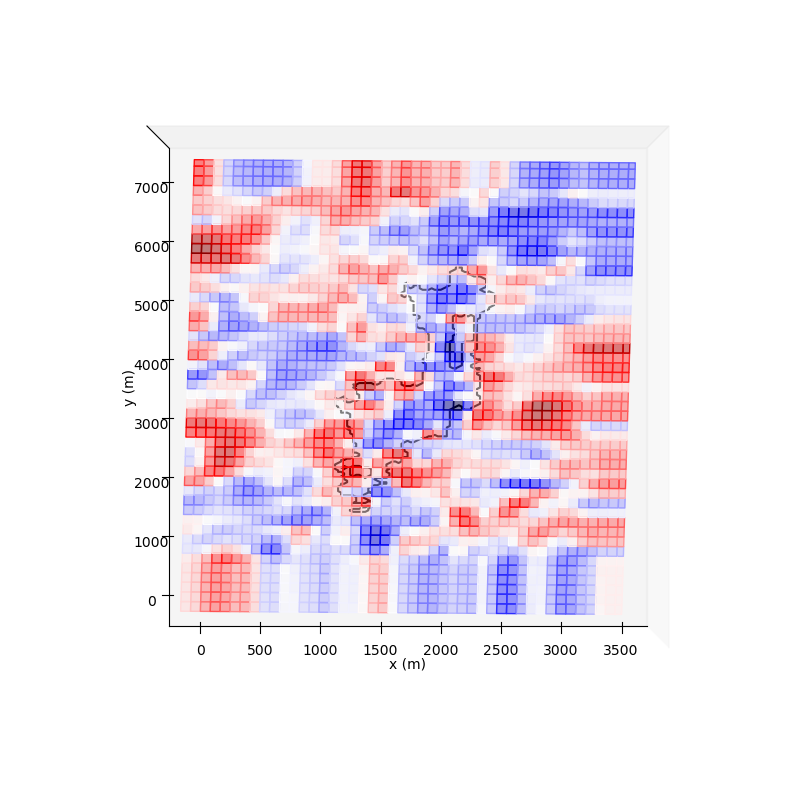

In [18]:
i = 1
LNo = -1
PlgNo = [0,1,2,3,4]
xb_layer,yb_layer,pn_layer = cpb.xb[LNo],cpb.yb[LNo],cpb.pn[LNo]
# plot the plume boundary
fig = plt.figure(figsize=(10,17))
ax = fig.add_subplot(111, projection='3d')
cN = plc.Normalize(vmin=np.amin(Ve[i]), vmax=np.amax(Ve[i]))
colors2 = plt.cm.seismic(cN(Vi[i]))
ax.plot_surface(xd-np.amin(xd),yd-np.amin(yd),np.zeros_like(yd),
                facecolors=colors2,alpha=0.5,shade=False)
for i in PlgNo:
    mask = (pn_layer==i)
    xbi = xb_layer[mask]
    ybi = yb_layer[mask]
    xbi = np.append(xbi,xbi[0])
    ybi = np.append(ybi,ybi[0])
    ax.plot(xbi-np.amin(xd),ybi-np.amin(yd),zs=np.zeros(len(xbi))-0.01,color='k')

ax.view_init(elev=90,azim=-90)
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
#ax.invert_xaxis()
ax.grid(False)
_ = ax.set_zticks([])
cb = fig.colorbar(cm.ScalarMappable(norm=cN, cmap='seismic'))
cb.ax.tick_params(labelsize=25)

In [19]:
# output CO2 plume boundary and y axis for matlab display  #add your path  #add your path  #add your path
r'''
for i in range(len(cpb.xb)):
    print(len(cpb.xb[i]))
    np.array(cpb.xb[i]).tofile(f'/scratch/gilbreth/pate2126/DKP_new/Co2_data/NNpred3D/cpbxb_{i}.dat')      
    np.array(cpb.yb[i]).tofile(f'/scratch/gilbreth/pate2126/DKP_new/Co2_data/NNpred3D/cpbyb_{i}.dat')      
    np.array(cpb.pn[i]).tofile(f'/scratch/gilbreth/pate2126/DKP_new/Co2_data/NNpred3D/cpbpn_{i}.dat')     
yd.tofile(f'../resources/label/yd.dat')
'''

"\nfor i in range(len(cpb.xb)):\n    print(len(cpb.xb[i]))\n    np.array(cpb.xb[i]).tofile(f'/scratch/gilbreth/pate2126/DKP_new/Co2_data/NNpred3D/cpbxb_{i}.dat')\n    np.array(cpb.yb[i]).tofile(f'/scratch/gilbreth/pate2126/DKP_new/Co2_data/NNpred3D/cpbyb_{i}.dat')\n    np.array(cpb.pn[i]).tofile(f'/scratch/gilbreth/pate2126/DKP_new/Co2_data/NNpred3D/cpbpn_{i}.dat')\nyd.tofile(f'../resources/label/yd.dat')\n"

## Compute the traveltime for all interfaces

In [20]:
# get the depth surfaces' arrivaltime
T_ref = arrivaltime(Di,Vi,Di[sidx])

## Display depth-to-time conversion for an example assemble

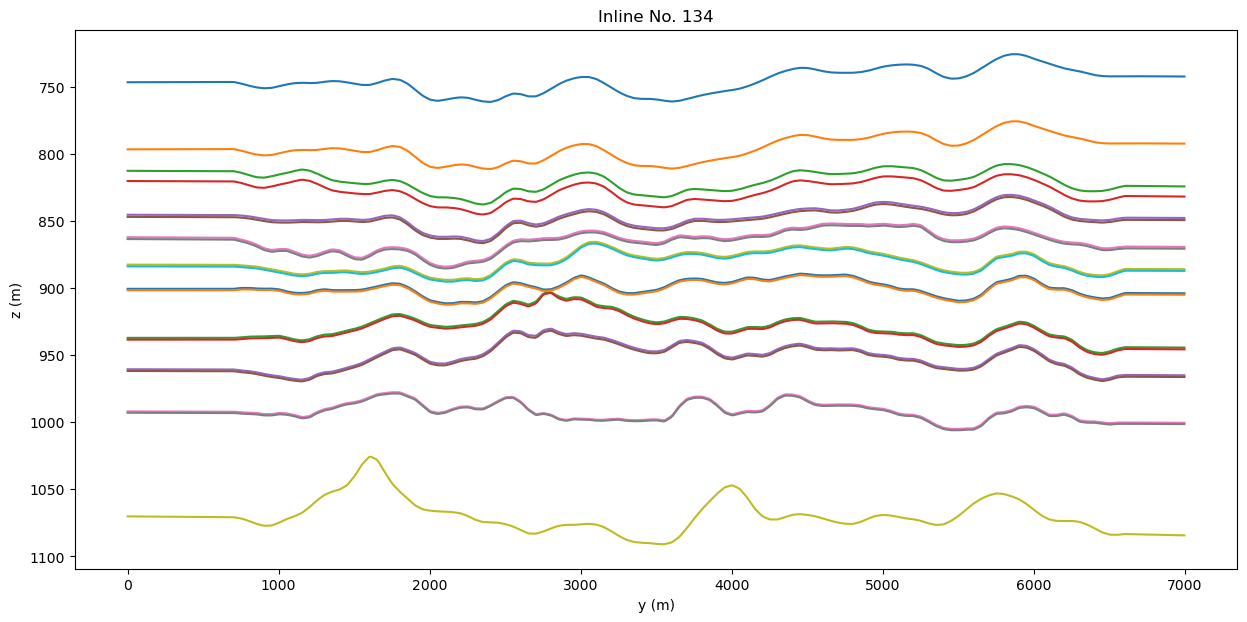

In [21]:
# display 2-way traveltime corresponding to all interfaces for given Inline section
ind_Is = [134]
ns = len(ind_Is)
fig,ax = plt.subplots(ns,1,figsize = (15,7*ns))
for j,k in enumerate(ind_Is):
    if ns == 1:
        tmp = ax
    else:
        tmp = ax[j]
    for i in range(nfd):
        tmp.plot(yd[0]-np.amin(yd[0]),Di[i,k,:])
    tmp.set_xlabel('y (m)')
    tmp.set_ylabel('z (m)')
    #tmp.set_ylim(0,2)
    tmp.invert_yaxis()
    _ = tmp.set_title(f'Inline No. {k}')

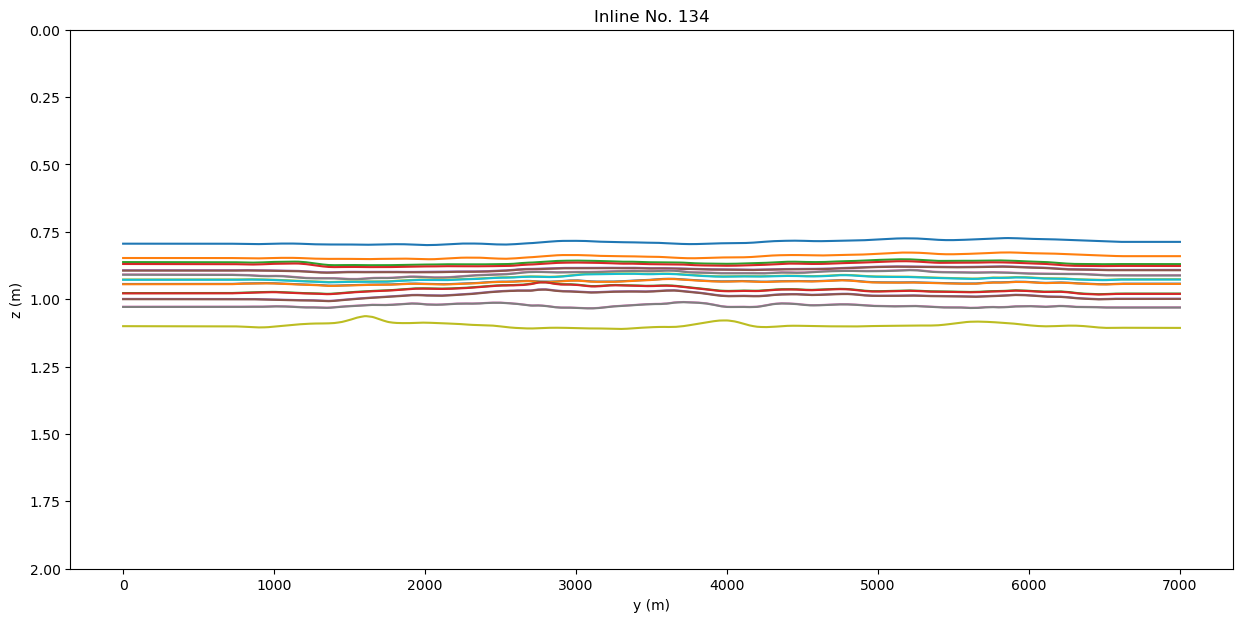

In [22]:
# display 2-way traveltime corresponding to all interfaces for given Inline section
ind_Is = [134]
ns = len(ind_Is)
fig,ax = plt.subplots(ns,1,figsize = (15,7*ns))
for j,k in enumerate(ind_Is):
    if ns == 1:
        tmp = ax
    else:
        tmp = ax[j]
    for i in range(nfd):
        tmp.plot(yd[0]-np.amin(yd[0]),T_ref[i,k,:])
    tmp.set_xlabel('y (m)')
    tmp.set_ylabel('z (m)')
    tmp.set_ylim(0,2)
    tmp.invert_yaxis()
    _ = tmp.set_title(f'Inline No. {k}')

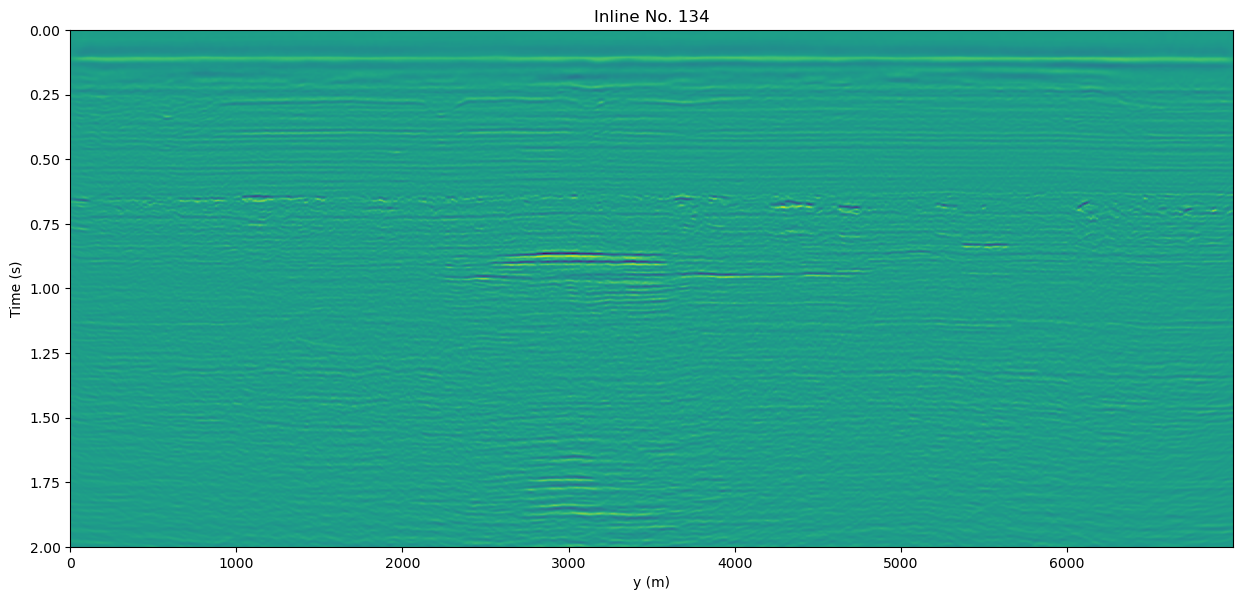

In [23]:
# display the given inline section
fig,ax = plt.subplots(ns,1,figsize = (15,7*ns))
for j,k in enumerate(ind_Is):
    if ns == 1:
        tmp = ax
    else:
        tmp = ax[j]
    for i in range(nfd):
        tmp.imshow(di[k].T,extent=(yd[0][0]-np.amin(yd[0]),yd[0][-1]-np.amin(yd[0]),2,0),aspect=7000/2*8/18)
    tmp.set_xlabel('y (m)')
    tmp.set_ylabel('Time (s)')
    tmp.set_ylim(0,2)
    tmp.invert_yaxis()
    _ = tmp.set_title(f'Inline No. {k}')

In [24]:
r'''## Smooth the time horizons horizontally
for i in range(ds.nf):
    T_ref[i] = gaussian_filter(T_ref[i],(10,10))'''

'## Smooth the time horizons horizontally\nfor i in range(ds.nf):\n    T_ref[i] = gaussian_filter(T_ref[i],(10,10))'

## Generate CO2 masks in 3D

In [25]:
# get all layers top and base arrival time
T_base = T_ref[-1:-18:-2,:,:] # top of the formatin
T_top = T_ref[-2:-19:-2,:,:] # bottom of the formation

In [26]:
mask_CO2 = cpb.CO2mask(xd,yd,td,T_top,T_base)

In [27]:
# smooth the mask along t,x and y direction
mask_CO2s = gaussian_filter1d(mask_CO2,sigma=1,axis=1)
mask_CO2s = gaussian_filter1d(mask_CO2s,sigma=1,axis=2)
mask_CO2s = gaussian_filter1d(mask_CO2s,sigma=3,axis=0)

## save the 3D mask and interface reflection arrival time

In [32]:
import os

# Make sure the output path exists
os.makedirs(outpath, exist_ok=True)
outpath = '/scratch/gilbreth/pate2126/DKP_new/resources/label'  #add your path

In [33]:
mask_CO2 = np.transpose(mask_CO2s,(1,2,0))
mask_CO2.tofile(f'{outpath}/masks.dat')

In [34]:
# save the T_base and T_top
T_base.tofile(f'{outpath}/T_base.dat')
T_top.tofile(f'{outpath}/T_top.dat')

## Display generated CO2 masks

In [35]:
mask_CO2s = np.fromfile(f'{outpath}/masks.dat',dtype=np.float32)
mask_CO2s = np.reshape(mask_CO2s,(d.nx,d.ny,nt))

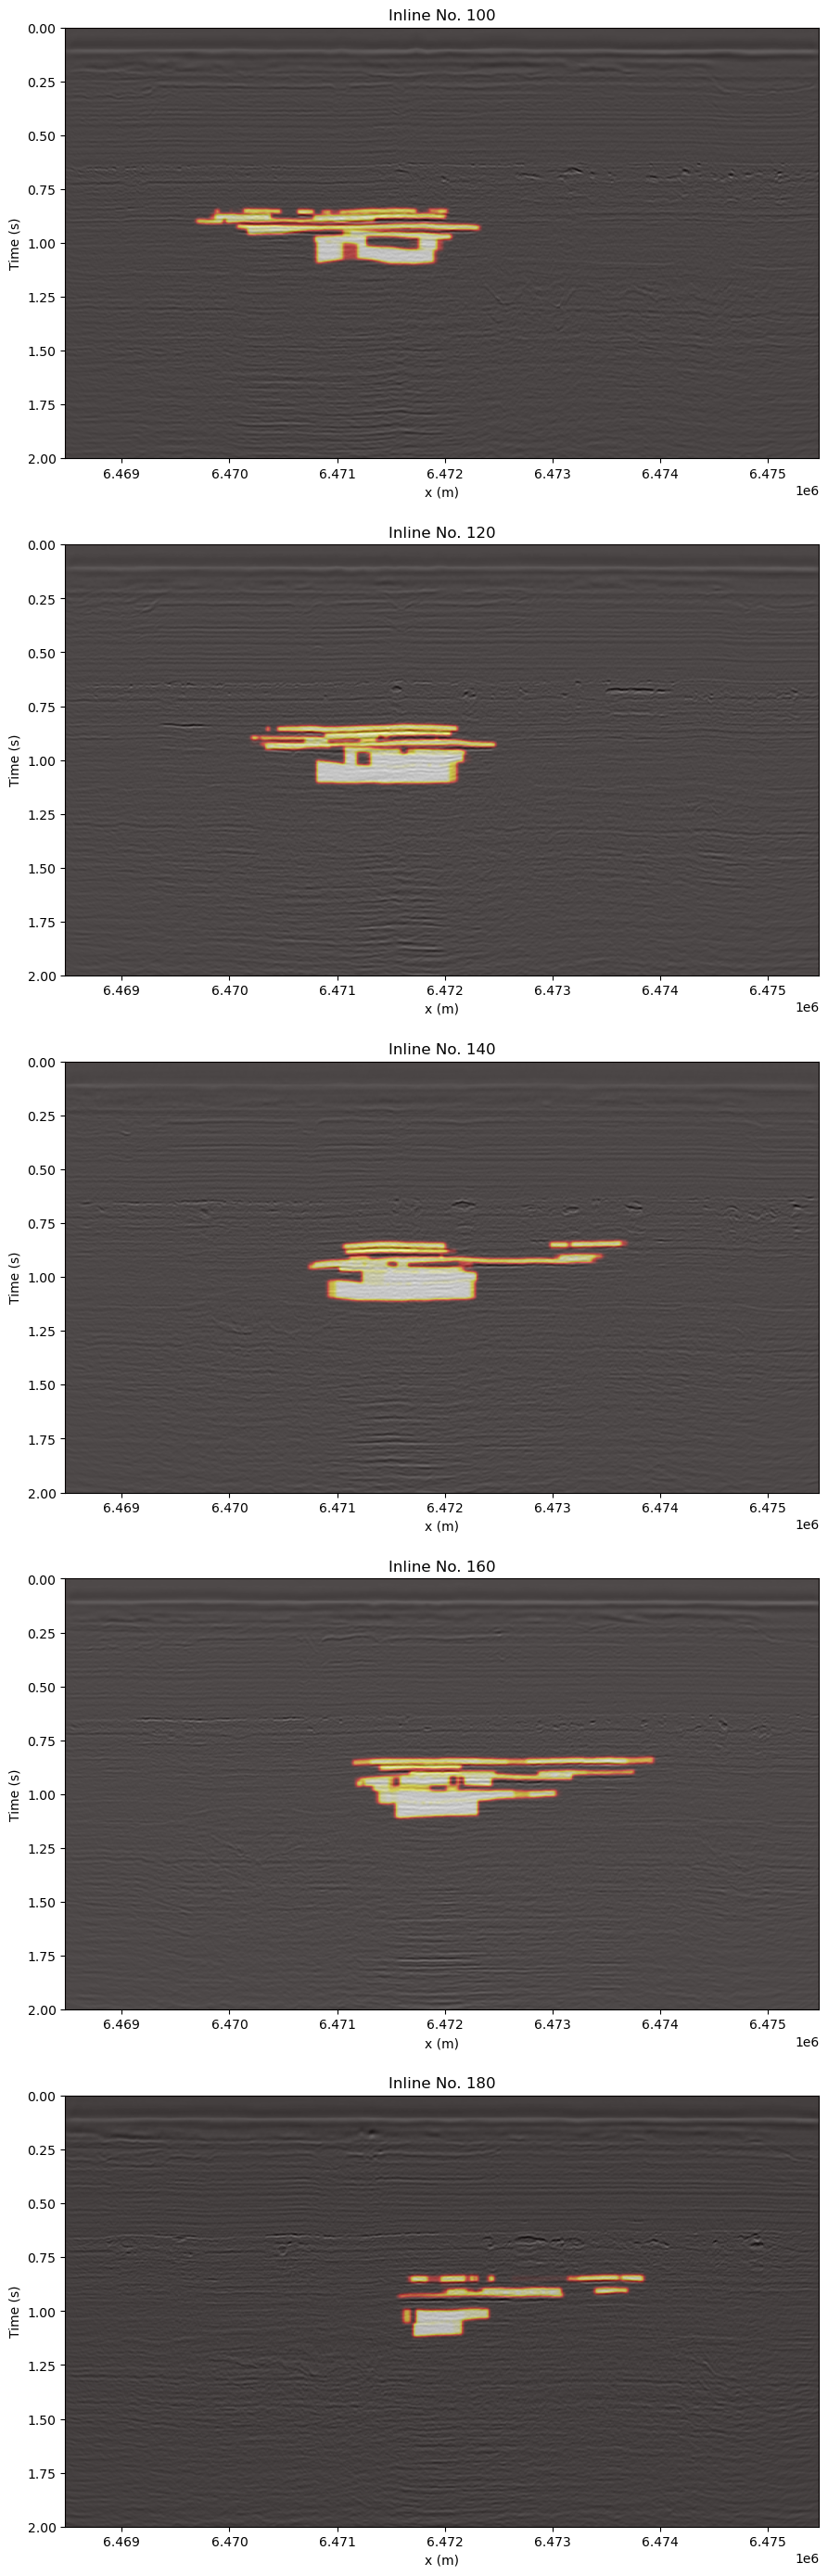

In [36]:
# display mask in sampled inline sections
ind_Is = np.array([100,120,140,160,180])
#ind_Is = [134,134]
ns = len(ind_Is)
fig,ax = plt.subplots(ns,1,figsize = (12,7*ns))
for j,i in enumerate(ind_Is):
    ax[j].imshow(di[i].T,extent=(yd[0,0],yd[0,-1],td[-1],0),
                 cmap='gray',aspect=2000,zorder=1)
    ax[j].imshow(mask_CO2s[i].T,extent=(yd[0,0],yd[0,-1],td[-1],0),
                 cmap='hot',alpha=0.5,aspect=2000,zorder=10)
    ax[j].set_ylabel('Time (s)')
    ax[j].set_xlabel('x (m)')
    ax[j].set_title(f'Inline No. {i}')

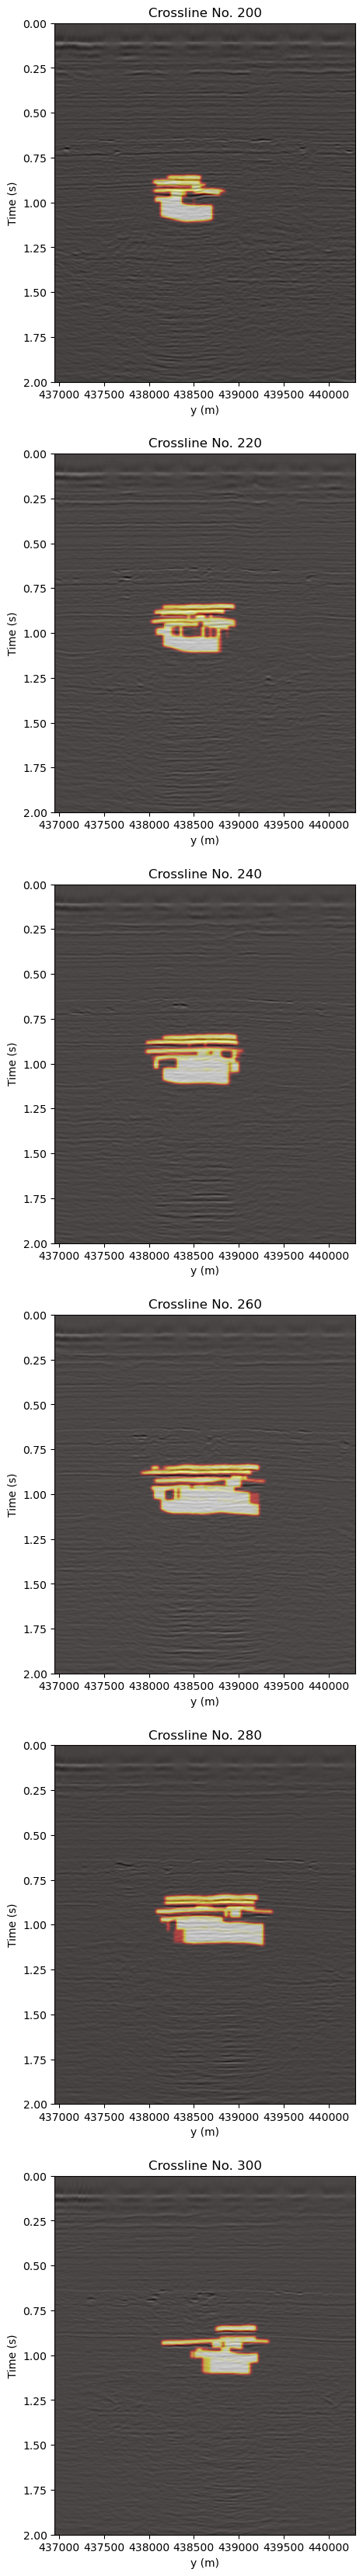

In [37]:
# display mask in sampled crossline sections
ind_Js = np.array([200,220,240,260,280,300])
ns = len(ind_Js)
fig,ax = plt.subplots(ns,1,figsize = (12,7*ns))
for j,i in enumerate(ind_Js):
    ax[j].imshow(di[:,i,:].T,extent=(xd[0,0],xd[-1,0],td[-1],0),
                 cmap='gray',aspect=2000,zorder=1)
    ax[j].imshow(mask_CO2s[:,i,:].T,extent=(xd[0,0],xd[-1,0],td[-1],0),
                 cmap='hot',alpha=0.5,aspect=2000,zorder=10)
    ax[j].set_ylabel('Time (s)')
    ax[j].set_xlabel('y (m)')
    ax[j].set_title(f'Crossline No. {i}')

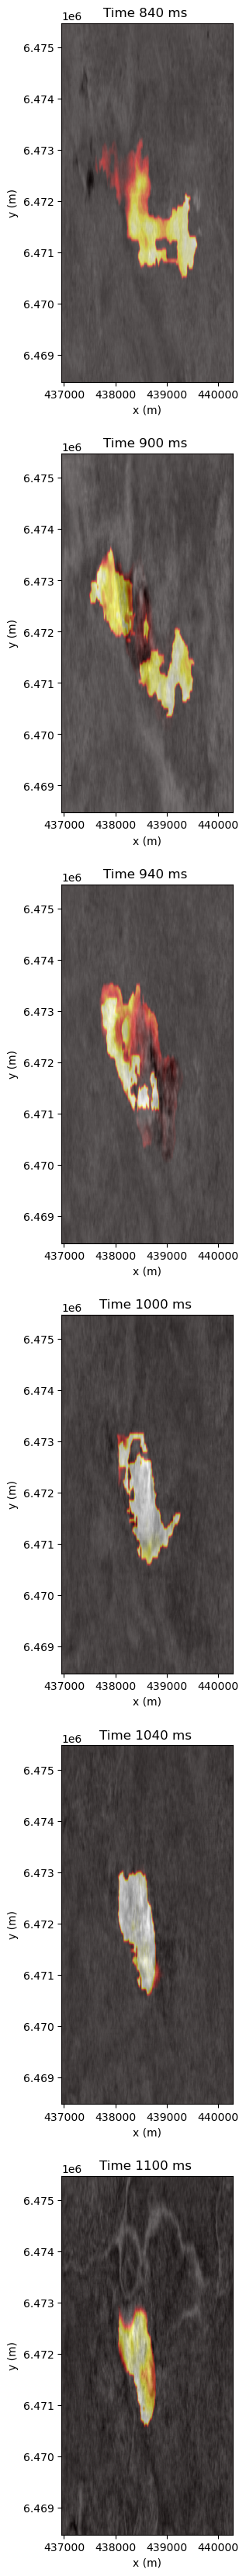

In [38]:
# display mask in sampled time slices
ind_Ts = np.array([420,450,470,500,520,550])
ns = len(ind_Ts)
fig,ax = plt.subplots(ns,1,figsize = (12,7*ns))
for j,i in enumerate(ind_Ts):
    ax[j].imshow(di[:,:,i],extent=(xd[0,0],xd[-1,0],yd[0,0],yd[0,-1]),
                 cmap='gray',aspect=1,zorder=1)
    ax[j].imshow(mask_CO2s[:,:,i],extent=(xd[0,0],xd[-1,0],yd[0,0],yd[0,-1]),
                 cmap='hot',alpha=0.5,aspect=1,zorder=10)
    ax[j].set_ylabel('y (m)')
    ax[j].set_xlabel('x (m)')
    ax[j].set_title(f'Time {i*2} ms ')